In [1]:
import torch
from torch import nn
import librosa
import joblib
import numpy as np
import pandas as pd
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Model

In [2]:
class MusicClassifier(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(
                in_features=input_features, out_features=256, dtype=torch.float32
            ),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=128, dtype=torch.float32),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(
                in_features=128, out_features=output_features, dtype=torch.float32
            ),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Preprocess data

In [3]:
def get_3sec_sample() -> list:
    # TODO Vérif
    # TODO Rewrite
    # audio, sample_rate = librosa.load('./extra_music/4/Freeze Corleone 667 - Freeze Raël.mp3', sr=None)
    # audio, sample_rate = librosa.load('./extra_music_old/The New Gypsies - Bandidos ft. Sofiane.mp3', sr=None)
    # audio, sample_rate = librosa.load('./extra_music_old/Freeze Corleone  Funk Raël (Prod. Congo funk).mp3', sr=None)
    # audio, sample_rate = librosa.load('./extra_music_old/Migos - Walk It Talk It ft. Drake (Official Video).mp3', sr=None)
    # audio, sample_rate = librosa.load('./extra_music_old/pink panther but its uk drill.mp3', sr=None)
    audio, sample_rate = librosa.load('./extra_music_old/13 ORGANISE - ETOILE SUR LE MAILLOT - MATTRACH GUITAR FREESTYLE.mp3', sr=None)






    segment_duration = 3  # Durée de chaque segment en secondes
    segment_length = int(sample_rate * segment_duration)
    segments = []

    # Effectuez la prédiction toutes les 3 secondes
    for i in range(0, len(audio), segment_length):
        segment = audio[i : i + segment_length]
        segments.append(segment)

    return segments

In [4]:
def audio_pipeline(audio):
    features = []

    # Chromagram
    chroma_stft = librosa.feature.chroma_stft(y=audio)
    features.append(np.mean(chroma_stft))
    features.append(np.var(chroma_stft))  # var => variance

    # RMS (Root Mean Square value for each frame)
    rms = librosa.feature.rms(y=audio)
    features.append(np.mean(rms))
    features.append(np.var(rms))

    # Calcul du Spectral centroid
    spectral_centroids = librosa.feature.spectral_centroid(y=audio)
    features.append(np.mean(spectral_centroids))
    features.append(np.var(spectral_centroids))

    # Spectral bandwith
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio)
    features.append(np.mean(spectral_bandwidth))
    features.append(np.var(spectral_bandwidth))

    # Calcul du spectral rolloff point
    rolloff = librosa.feature.spectral_rolloff(y=audio)
    features.append(np.mean(rolloff))
    features.append(np.var(rolloff))

    # Calcul du ZCR (Zero Crossing Rate)
    zcr = librosa.zero_crossings(audio)
    # features.append(np.sum(zcr))  # Custom
    features.append(np.mean(zcr))
    features.append(np.var(zcr))

    # Harmonic
    harmony = librosa.effects.harmonic(y=audio)
    features.append(np.mean(harmony))
    features.append(np.var(harmony))

    # Tempo
    tempo = librosa.feature.tempo(y=audio)
    features.append(tempo[0])

    # Calcul des moyennes des MFCC
    mfcc = librosa.feature.mfcc(y=audio)
    for x in mfcc:
        features.append(np.mean(x))
        features.append(np.var(x))

    return features

In [5]:
scaler = joblib.load("../resources/standard_scaler_pytorch_model_last.pkl")

dfs = []
segments = get_3sec_sample()

for audio in segments:
    # Perform audio feature extraction
    features = audio_pipeline(audio)

    # Scale the features using the loaded scaler
    scaled_features = scaler.transform([features])

    # Create a DataFrame
    column_names = [
        "chroma_stft_mean",
        "chroma_stft_var",
        "rms_mean",
        "rms_var",
        "spectral_centroid_mean",
        "spectral_centroid_var",
        "spectral_bandwidth_mean",
        "spectral_bandwidth_var",
        "rolloff_mean",
        "rolloff_var",
        "zero_crossing_rate_mean",
        "zero_crossing_rate_var",
        "harmony_mean",
        "harmony_var",
        "tempo",
        "mfcc1_mean",
        "mfcc1_var",
        "mfcc2_mean",
        "mfcc2_var",
        "mfcc3_mean",
        "mfcc3_var",
        "mfcc4_mean",
        "mfcc4_var",
        "mfcc5_mean",
        "mfcc5_var",
        "mfcc6_mean",
        "mfcc6_var",
        "mfcc7_mean",
        "mfcc7_var",
        "mfcc8_mean",
        "mfcc8_var",
        "mfcc9_mean",
        "mfcc9_var",
        "mfcc10_mean",
        "mfcc10_var",
        "mfcc11_mean",
        "mfcc11_var",
        "mfcc12_mean",
        "mfcc12_var",
        "mfcc13_mean",
        "mfcc13_var",
        "mfcc14_mean",
        "mfcc14_var",
        "mfcc15_mean",
        "mfcc15_var",
        "mfcc16_mean",
        "mfcc16_var",
        "mfcc17_mean",
        "mfcc17_var",
        "mfcc18_mean",
        "mfcc18_var",
        "mfcc19_mean",
        "mfcc19_var",
        "mfcc20_mean",
        "mfcc20_var",
    ]

    df = pd.DataFrame(scaled_features, columns=column_names)
    dfs.append(df)

print(len(dfs), " 3sec samples extracted and preprocessed")

43  3sec samples extracted and preprocessed


# Predict

In [6]:
genre_mapping = {
    0: "Blues",
    1: "Classical",
    2: "Country",
    3: "Disco",
    4: "Hiphop",
    5: "Jazz",
    6: "Metal",
    7: "Pop",
    8: "Reggae",
    9: "Rock",
}

In [7]:
genre_mapping_inverse = {
    "Blues": 0,
    "Classical": 1,
    "Country": 2,
    "Disco": 3,
    "Hiphop": 4,
    "Jazz": 5,
    "Metal": 6,
    "Pop": 7,
    "Reggae": 8,
    "Rock": 9,
}

In [8]:
# Load the weights
my_model = MusicClassifier(input_features=55, output_features=10)
# my_model.load_state_dict(
#     torch.load(
#         f="../resources/actual_model_fast.pth", map_location=torch.device("cpu")
#     )
# )
my_model.load_state_dict(
    torch.load(
        f="./trained_with_drive_model.pth", map_location=torch.device("cpu")
    )
)

<All keys matched successfully>

In [9]:
my_model.eval()

class_predictions = []
raw_results = []

for df in dfs:
    y_logits = my_model(torch.from_numpy(df.to_numpy()).type(torch.float32))
    y_softmax = torch.softmax(y_logits, dim=1)
    y_pred = y_softmax.argmax(dim=1)

    # print(genre_mapping[y_pred.detach().numpy()[0]])
    # print(list(torch.round(y_softmax * 1000) / 1000))

    raw_results.append(y_softmax.detach().numpy())
    class_predictions.append(genre_mapping[y_pred.detach().numpy()[0]])

unique_values = set(class_predictions)
actual_best = 0
for elt in unique_values:
    if class_predictions.count(elt) > actual_best:
        actual_best = class_predictions.count(elt)
        prediction = elt
    print(elt, class_predictions.count(elt))

print("Results =>", prediction, "(", genre_mapping_inverse[prediction], ")")

Pop 2
Jazz 4
Classical 11
Hiphop 5
Reggae 16
Blues 5
Results => Reggae ( 8 )


In [10]:
real_class = 4 # ! Flexibiliser
kept_dfs: List[pd.DataFrame] = []

for i in range(len(dfs)):
    sorted_array = np.sort(raw_results[i][0])[::-1]
    # Keep only dfs when the real class i the first or second predicted by the model !
    if raw_results[i][0][real_class] == sorted_array[0] or (raw_results[i][0][real_class] == sorted_array[1] and raw_results[i][0][real_class] > 0):
        # print(raw_results[i][0][real_class])
        kept_dfs.append(dfs[i])

print("df_length =>",len(kept_dfs))

df_length => 16


# Grow dataset with new data

In [11]:
def concat_dfs(dfs: List[pd.DataFrame], real_class):
    # Creating new df from processed input
    for i in range(len(dfs)):
        if i == 0:
            new_df = pd.DataFrame(dfs[i], columns=column_names)
        else:
            new_df = pd.concat([new_df, dfs[i]], axis=0)
    new_df["label"] = real_class

    # Créer dataset enrichie (csv)
    original_df = pd.read_csv(
        "../resources/original_dataset.csv"
    )  # ! Fait ça teh l'afaire
    # TODO Change to actual

    concatened_dataset = pd.concat([original_df, new_df], axis=0)

    concatened_dataset.to_csv("./actual_dataset.csv", index=False)

In [12]:
concat_dfs(kept_dfs, real_class)

# Training

In [13]:
def training_loop(MusicClassifier):
    # TODO: Externalise this
    # Init le model
    torch.manual_seed(42)
    model = MusicClassifier(input_features=55, output_features=10)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.011)

    def accuracy_fn(y_true, y_pred):
        correct = (
            torch.eq(input=y_true, other=y_pred).sum().item()
        )  # torch.eq() calculates where two tensors are equal
        acc = (correct / len(y_pred)) * 100  # Calcul simple de pourcentage
        return acc

    # Prepare data
    df = pd.read_csv("../resources/actual_dataset.csv")
    # df = pd.read_csv("/app/resources/original_dataset.csv")
    X = torch.from_numpy(df.drop(columns=["label"]).to_numpy()).type(torch.float32)
    y = torch.from_numpy(df["label"].to_numpy()).type(torch.long)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Training loop
    torch.manual_seed(42)
    epochs = 125
    for epoch in range(epochs + 1):
        """
        Train
        """
        model.train()

        # 1. Forward pass
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # 2. Metrics
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

        # 2.1 Save metrics
        # loss_history.append(loss.cpu().detach().numpy())
        # acc_history.append(acc)

        # 3. Zero Grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimmizer step
        optimizer.step()

        """
        Test
        """
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass
            y_test_logits = model(X_test)
            y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

            # 2. Metrics
            test_loss = loss_fn(y_test_logits, y_test)
            test_acc = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

            # 2.1 Save metrics
            # test_loss_history.append(test_loss.cpu().detach().numpy())
            # test_acc_history.append(test_acc)
            # cm = confusion_matrix(y_test, y_test_pred.numpy())
            # display(ConfusionMatrixDisplay(cm).plot())

        # Print out what's happening
        if epoch % 25 == 0:
                print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
    # if epoch == 125:
    cm = confusion_matrix(y_test, y_test_pred.numpy())
    print(ConfusionMatrixDisplay(cm).plot())

Epoch: 0 | Loss: 2.29285, Acc: 12.11% | Test Loss: 1.88716, Test Acc: 37.39%


/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Epoch: 25 | Loss: 0.60037, Acc: 78.96% | Test Loss: 0.65277, Test Acc: 77.22%


Epoch: 50 | Loss: 0.31458, Acc: 88.92% | Test Loss: 0.45170, Test Acc: 85.14%


Epoch: 75 | Loss: 0.16288, Acc: 94.48% | Test Loss: 0.39714, Test Acc: 88.16%


Epoch: 100 | Loss: 0.10911, Acc: 96.19% | Test Loss: 0.38385, Test Acc: 90.14%


Epoch: 125 | Loss: 0.07611, Acc: 97.63% | Test Loss: 0.36349, Test Acc: 90.69%


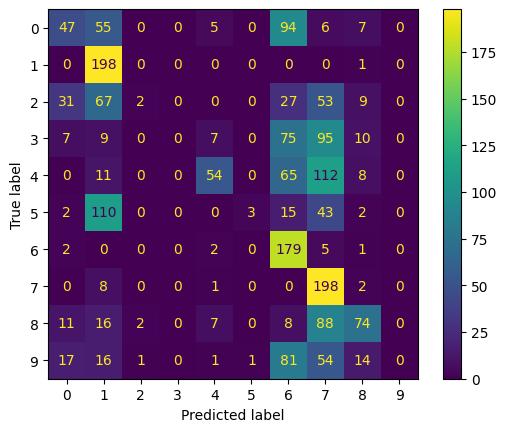

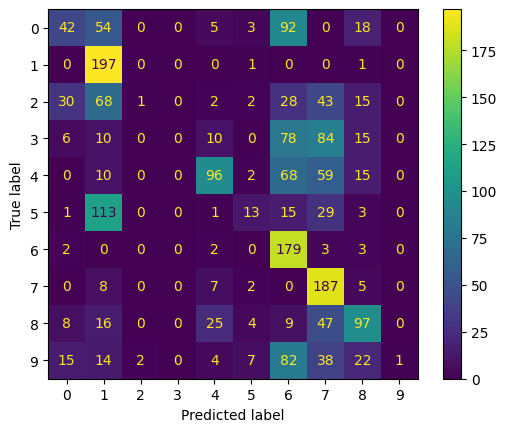

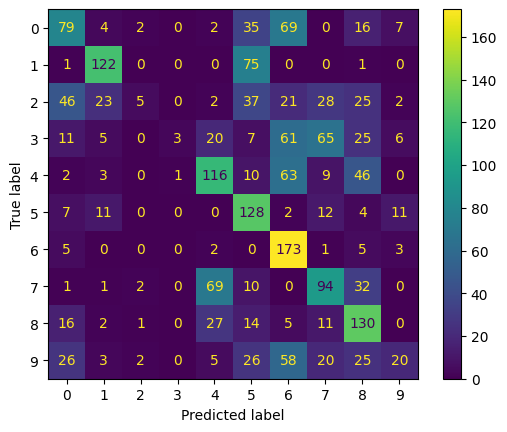

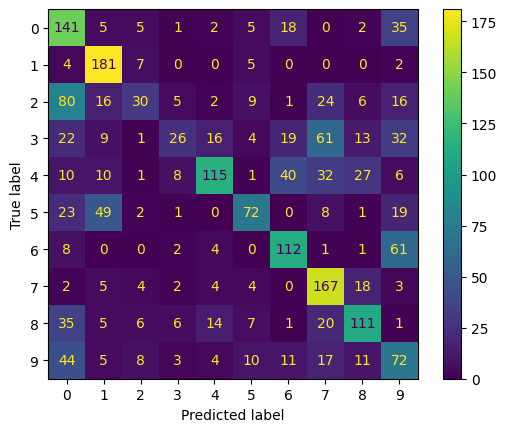

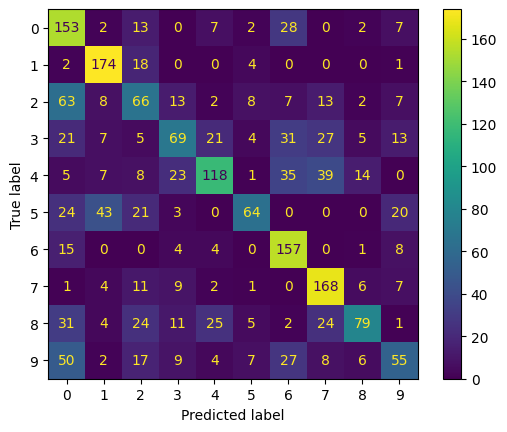

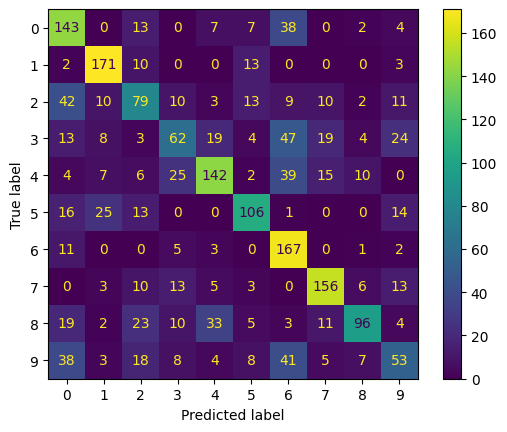

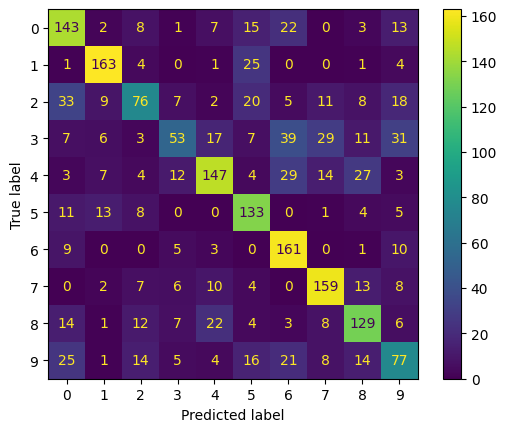

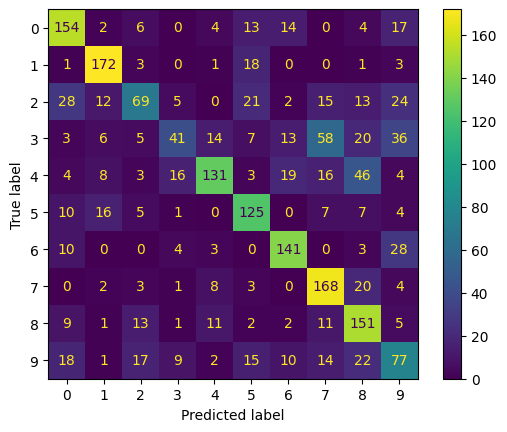

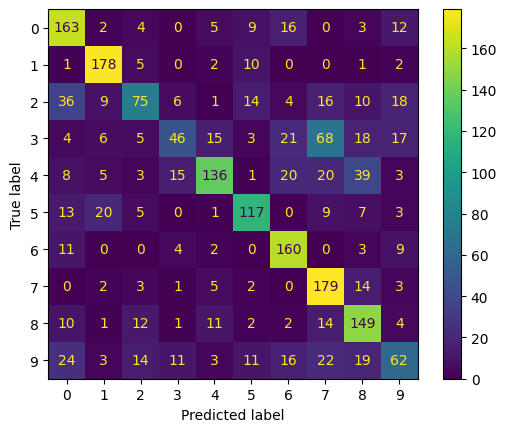

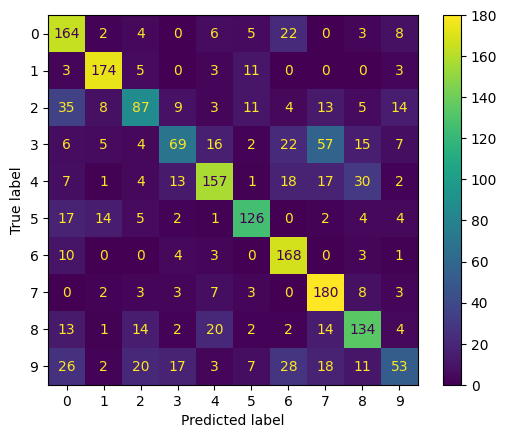

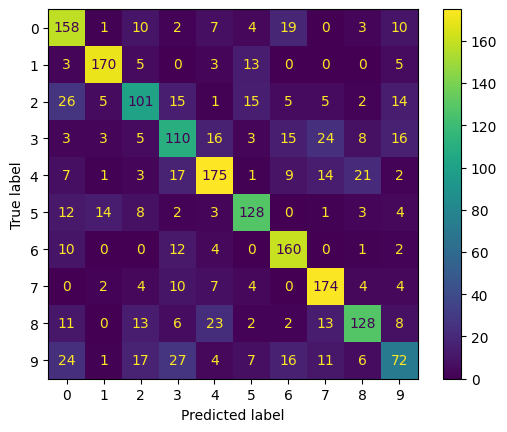

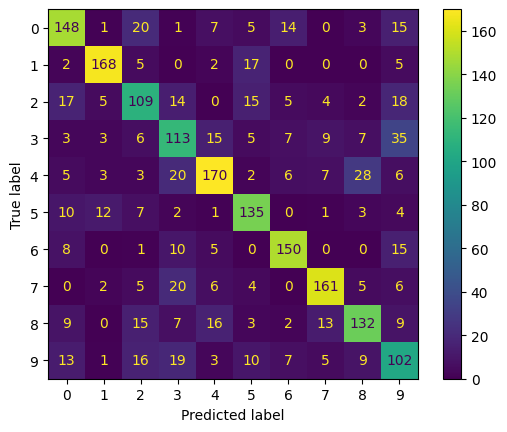

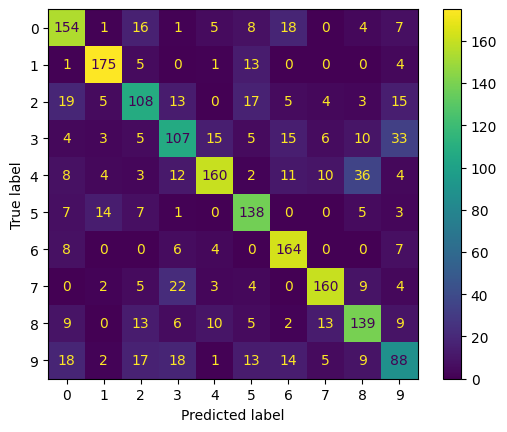

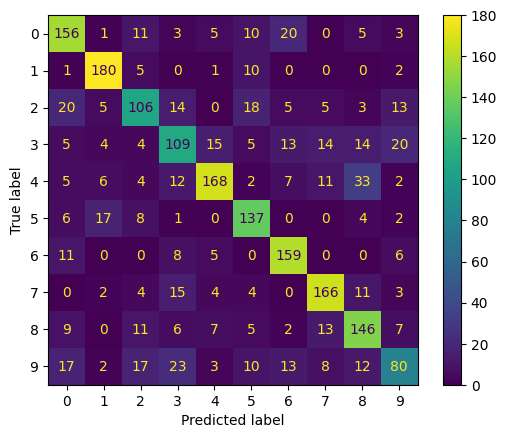

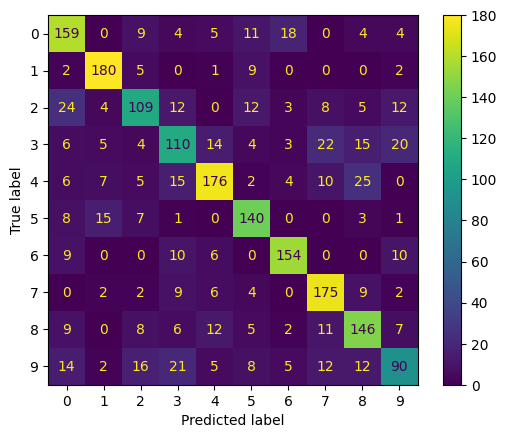

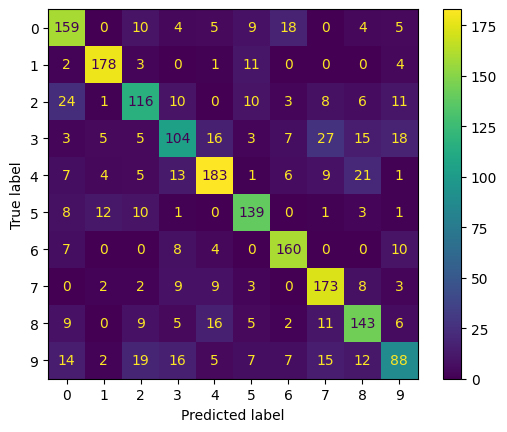

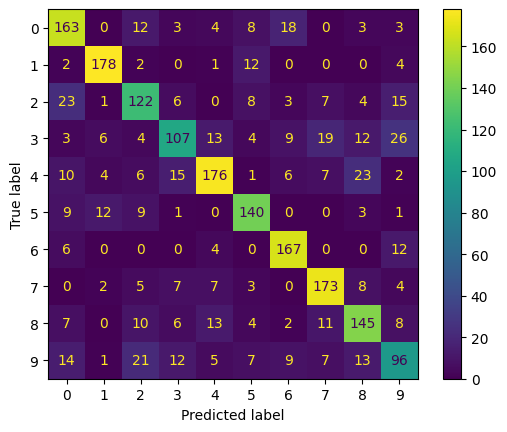

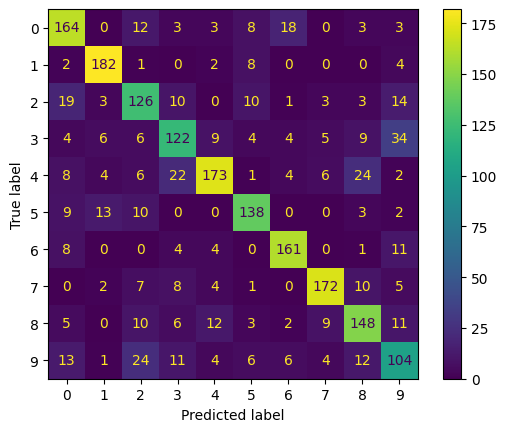

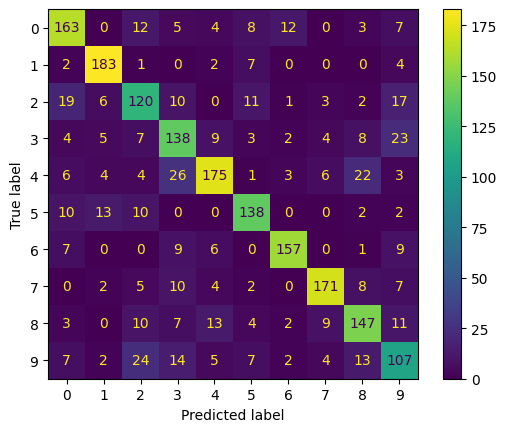

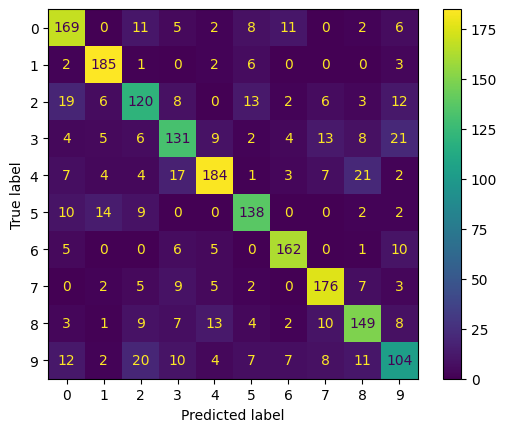

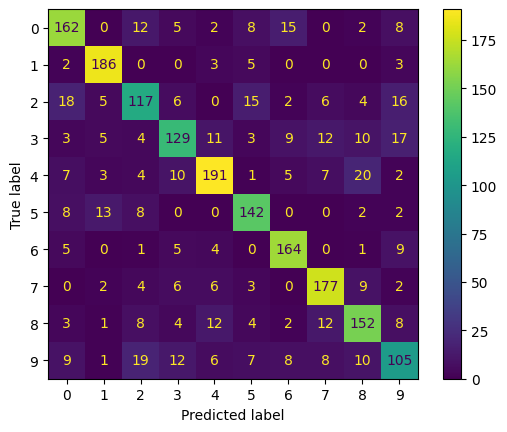

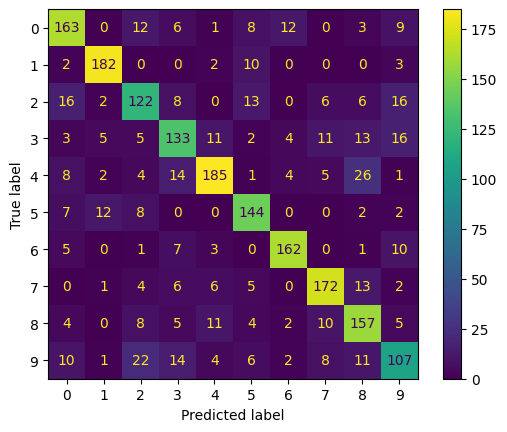

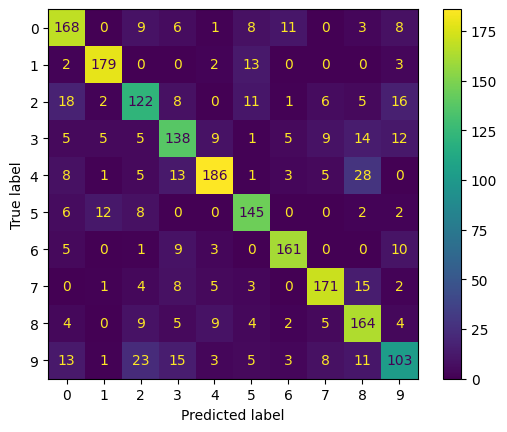

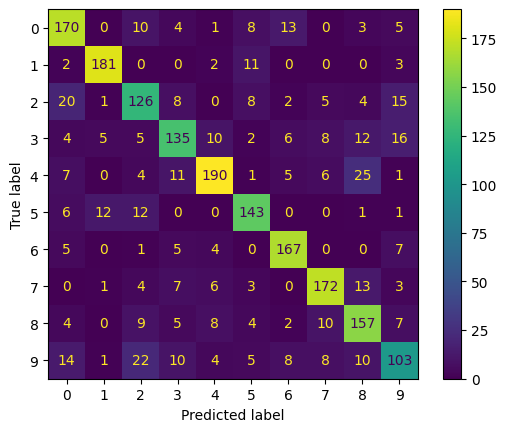

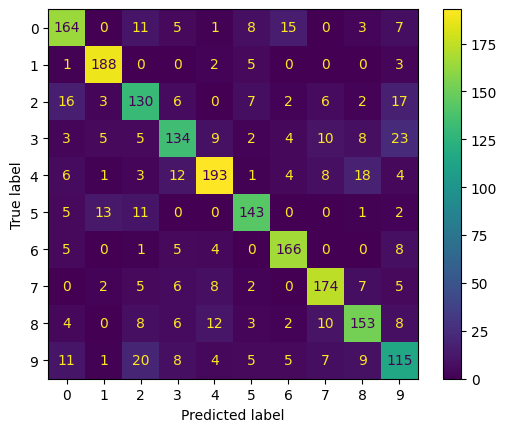

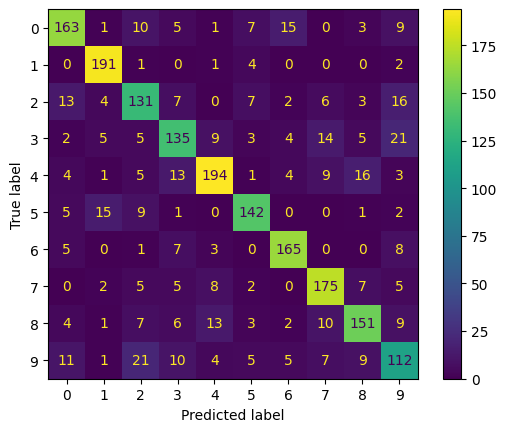

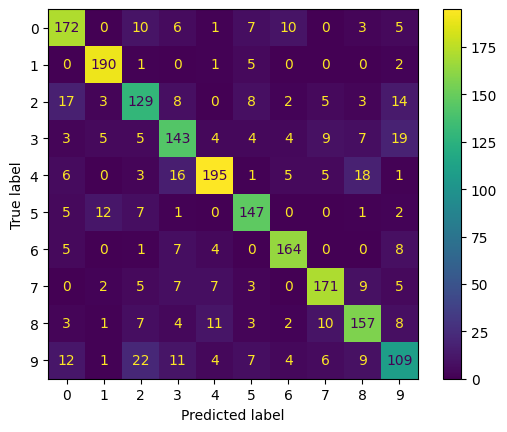

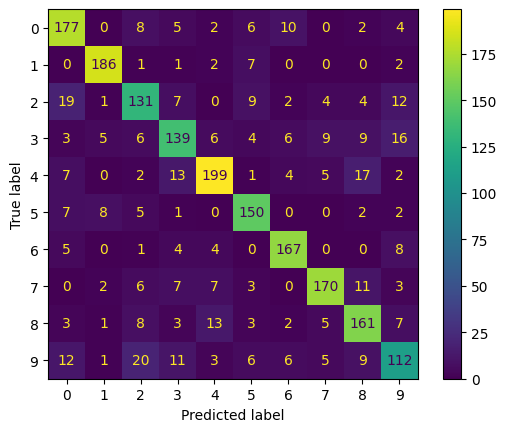

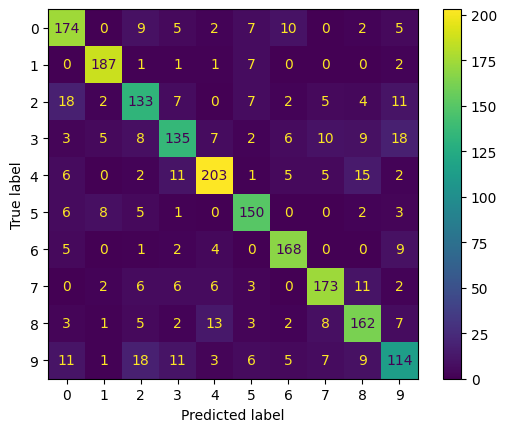

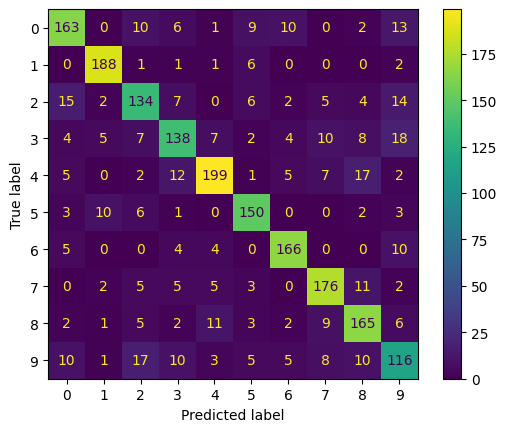

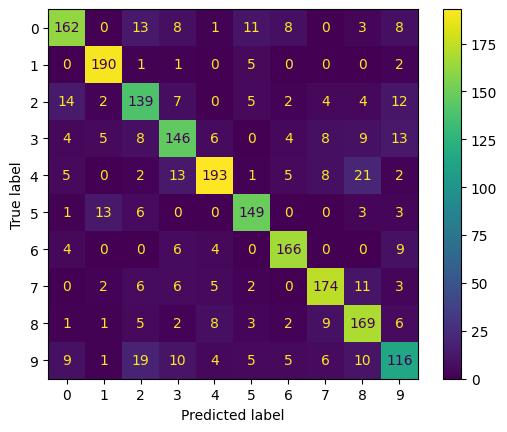

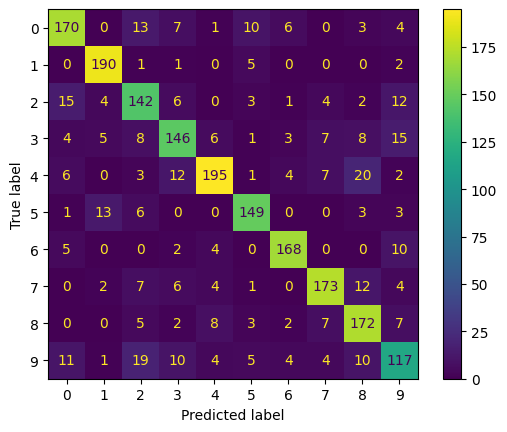

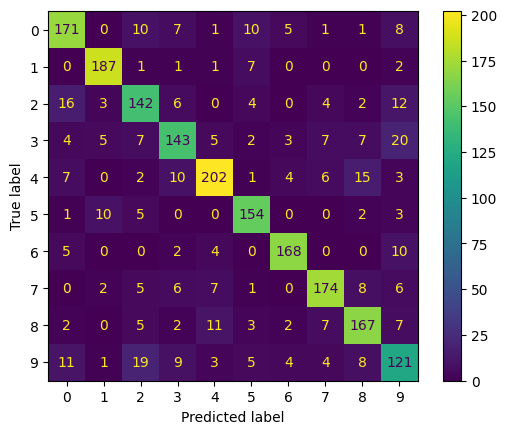

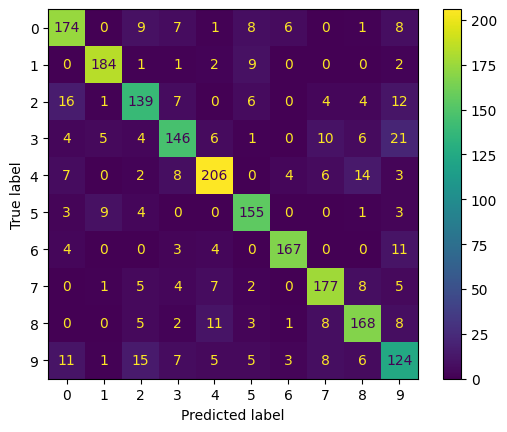

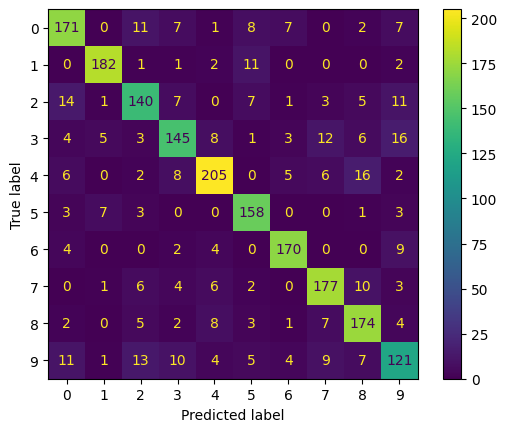

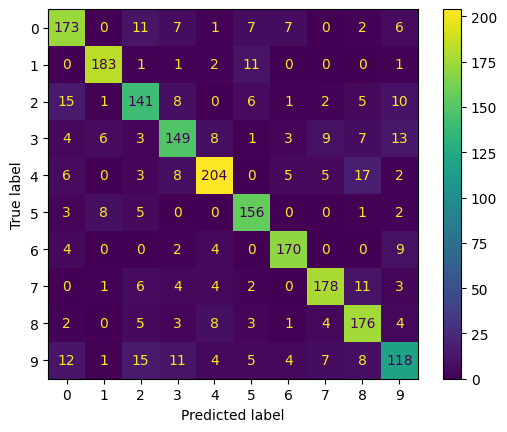

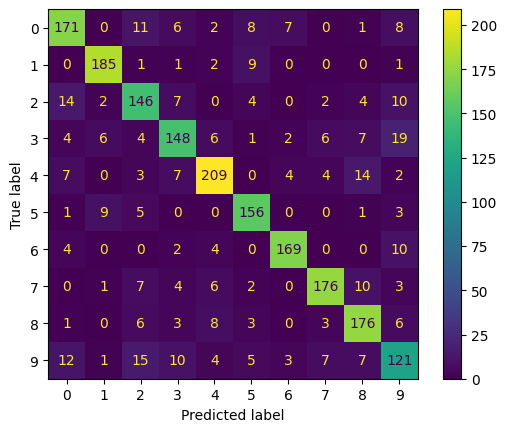

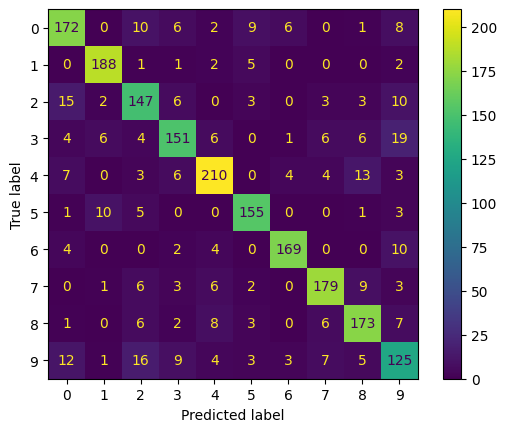

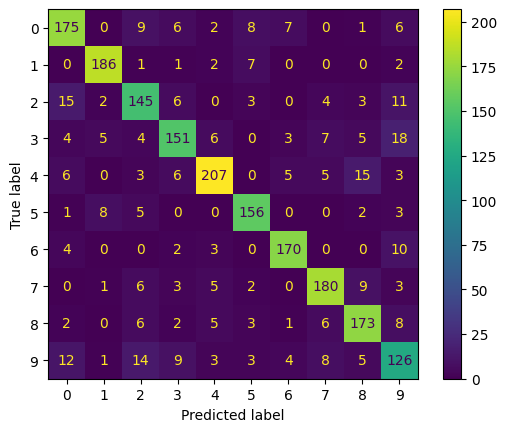

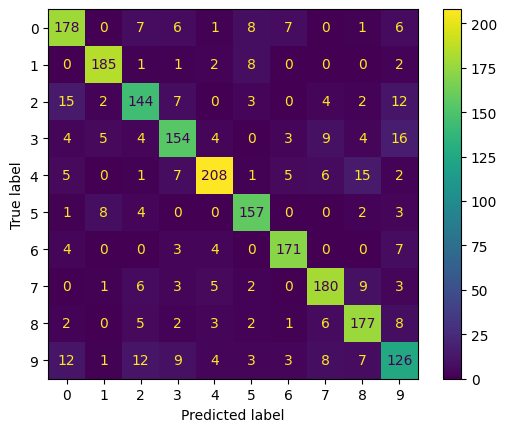

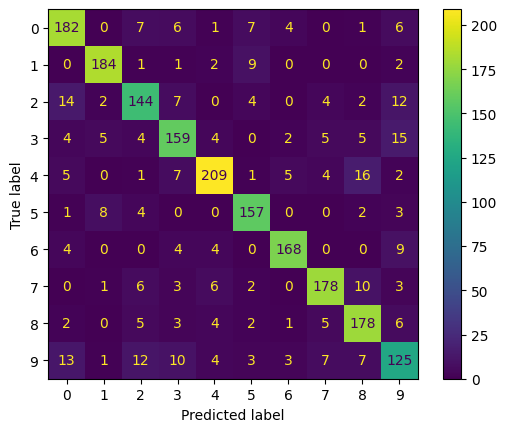

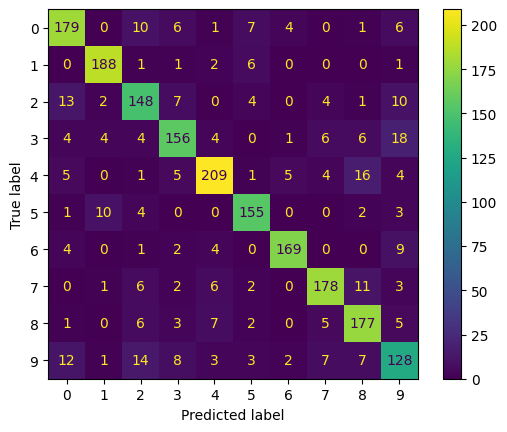

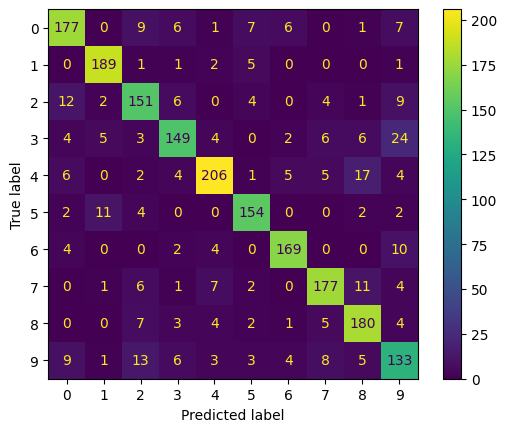

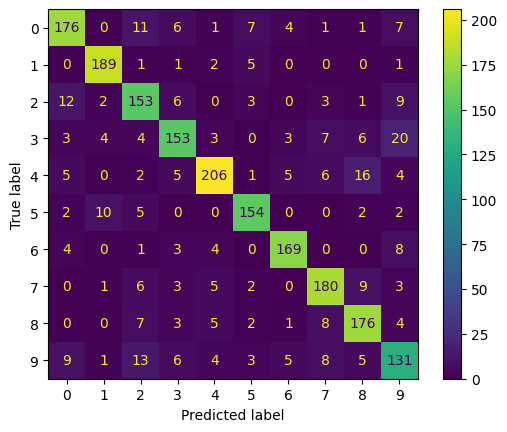

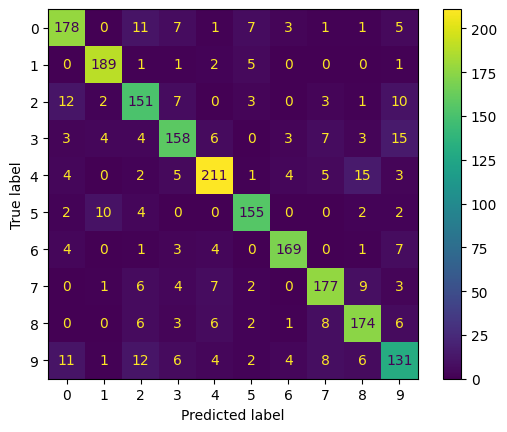

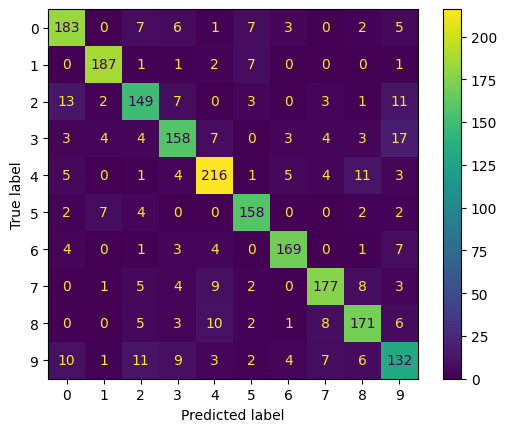

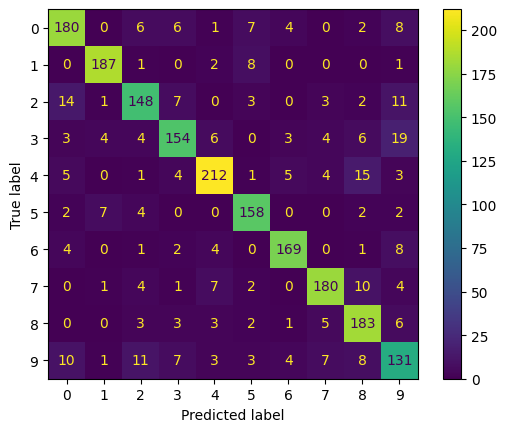

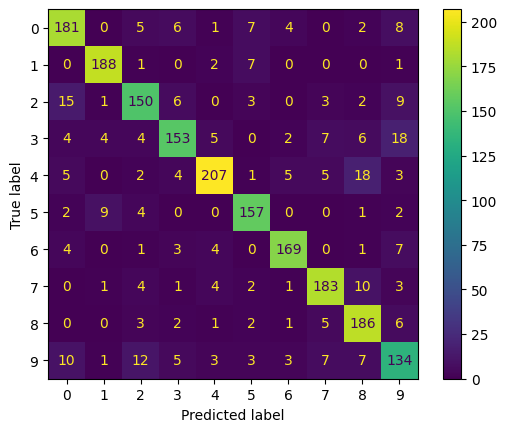

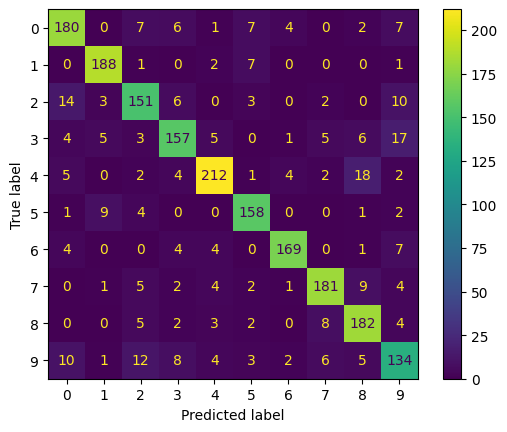

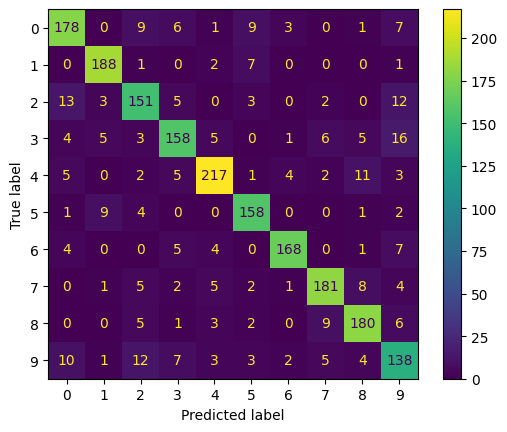

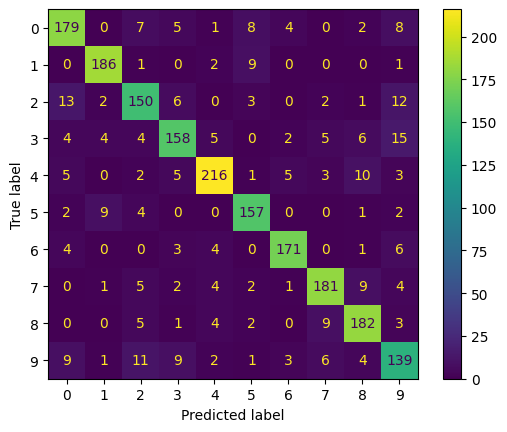

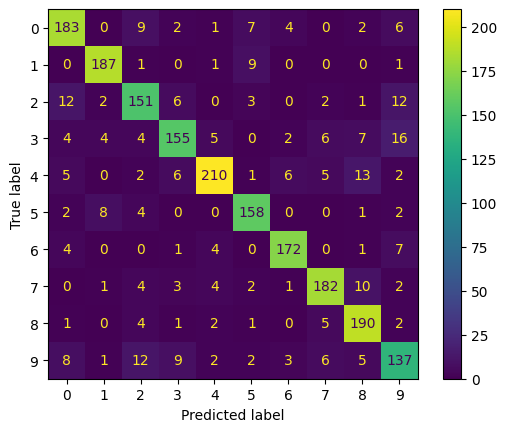

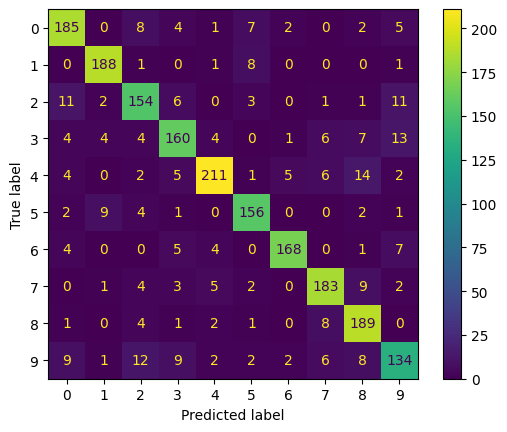

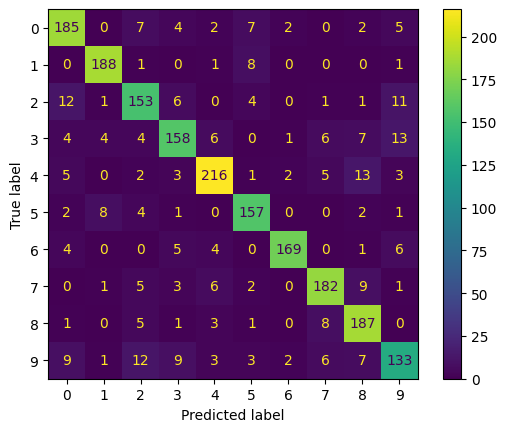

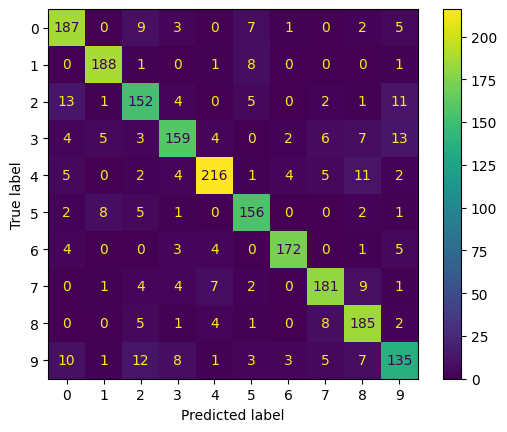

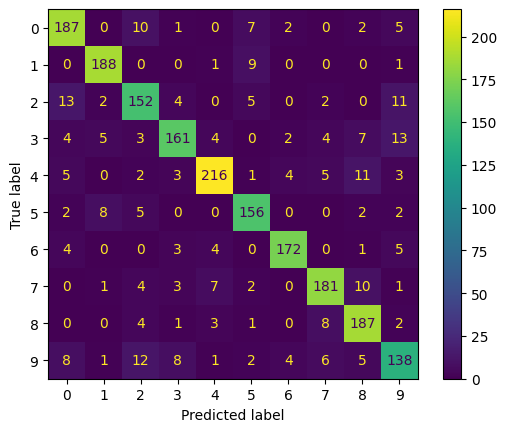

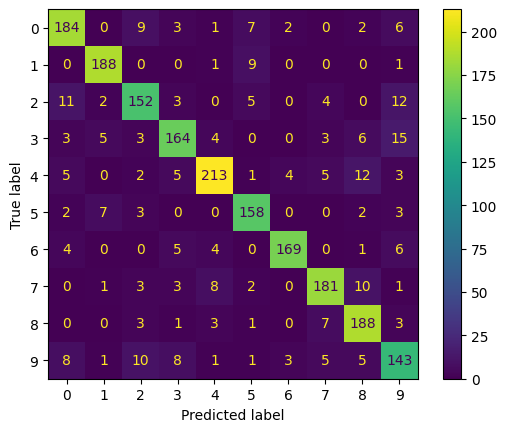

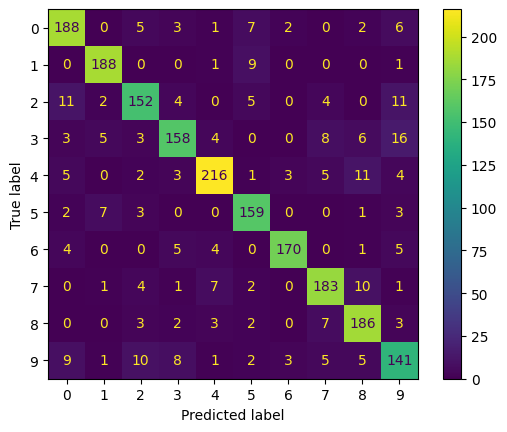

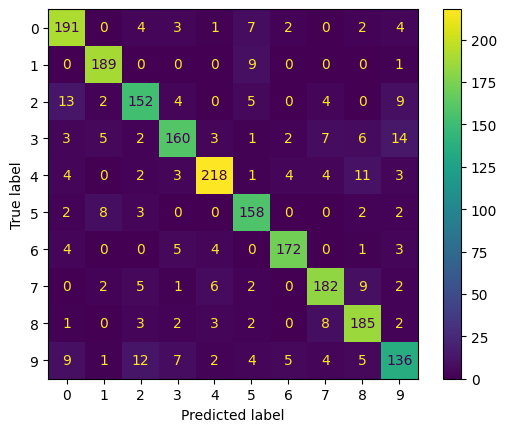

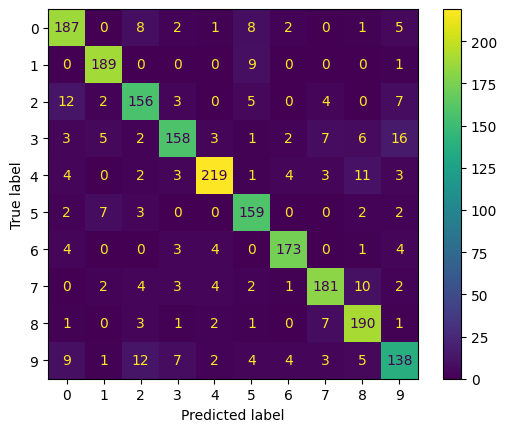

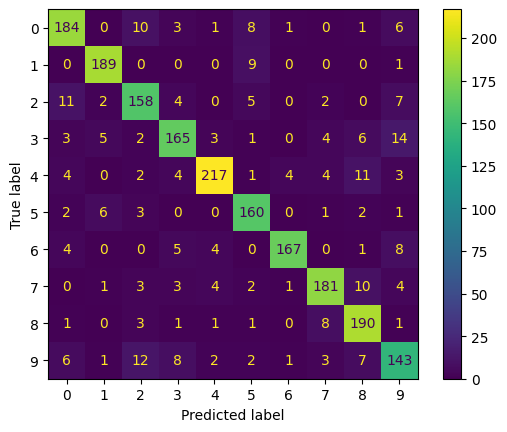

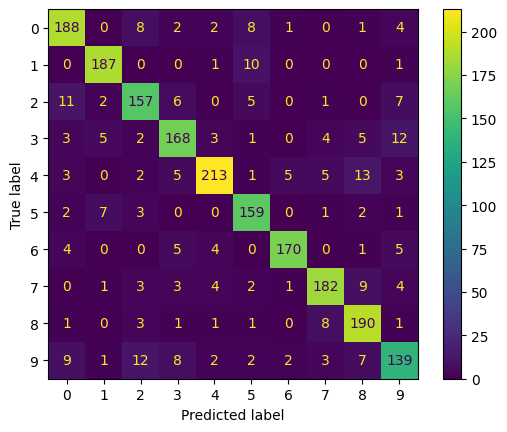

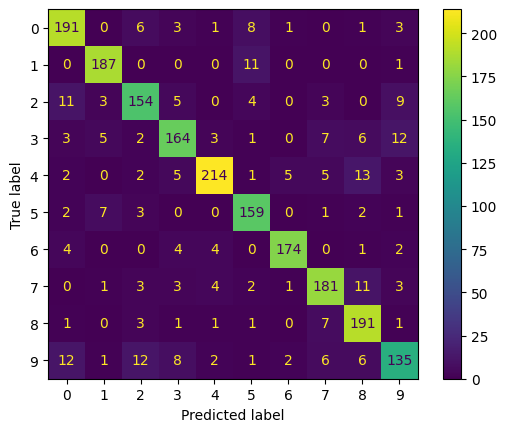

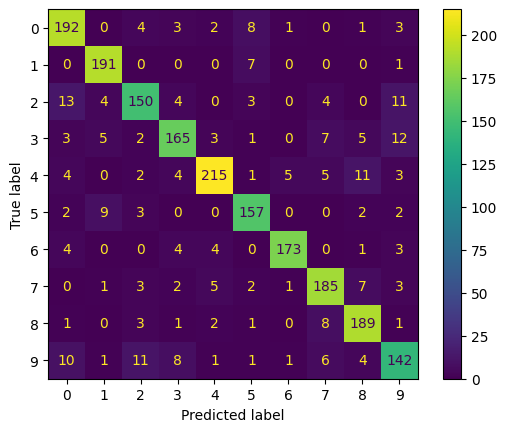

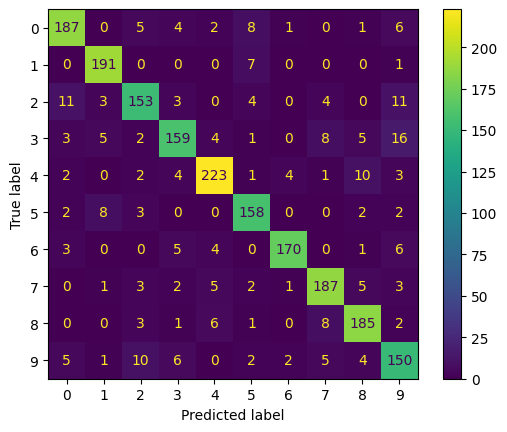

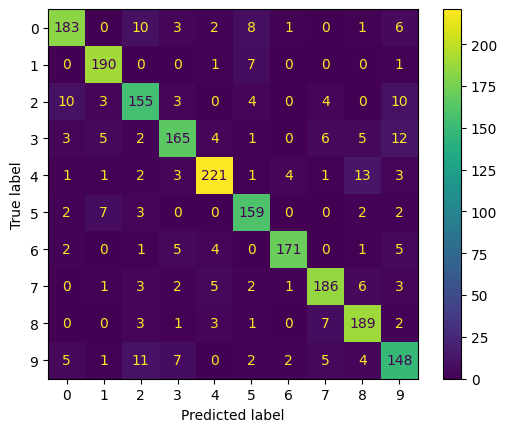

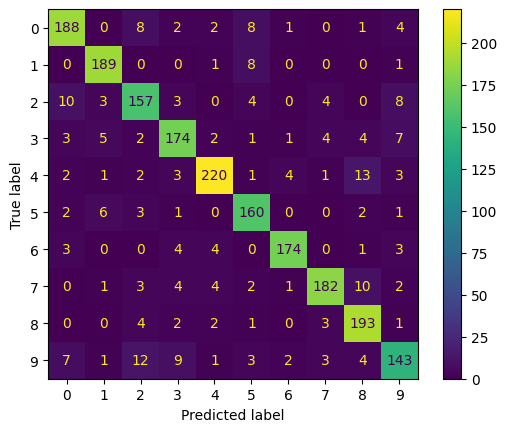

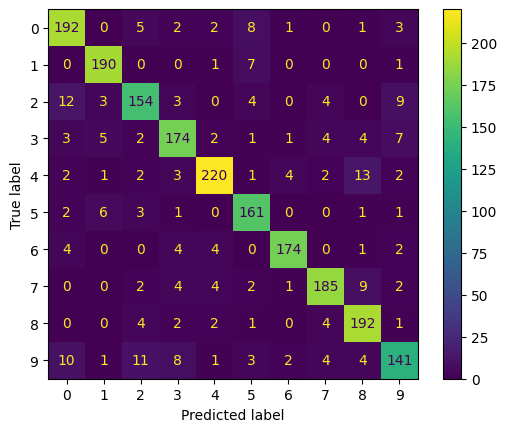

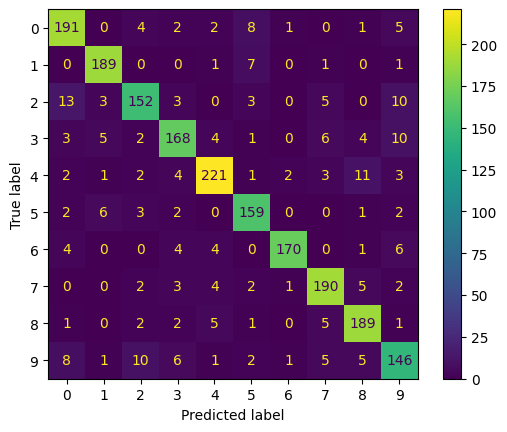

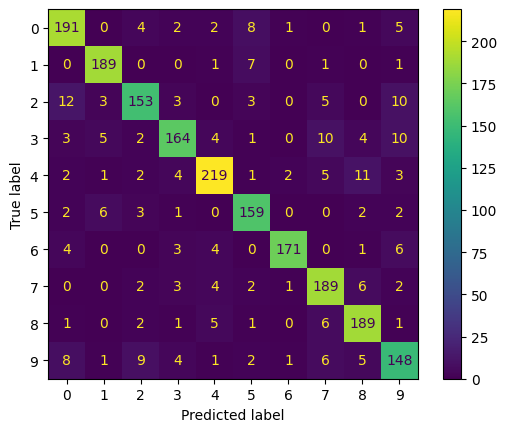

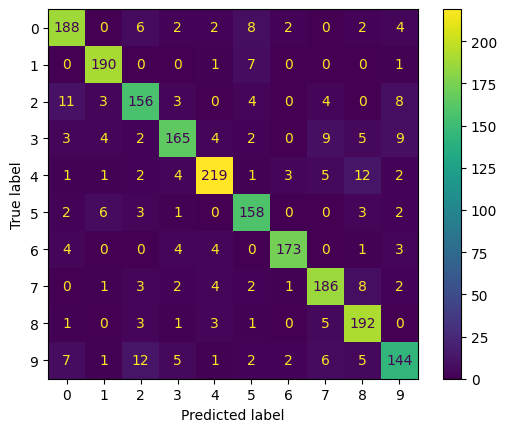

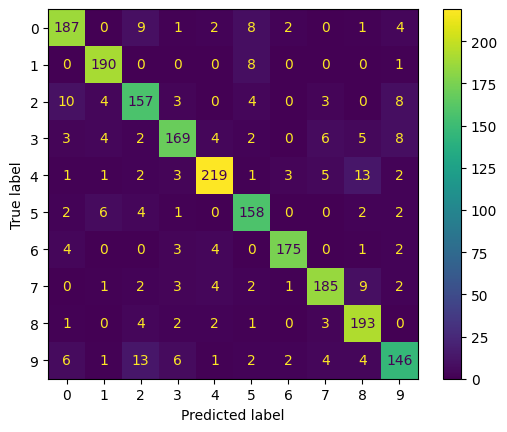

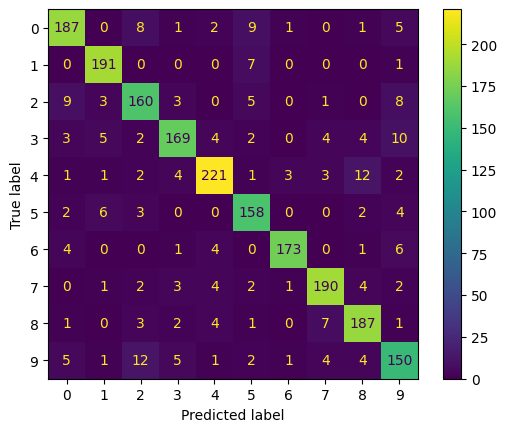

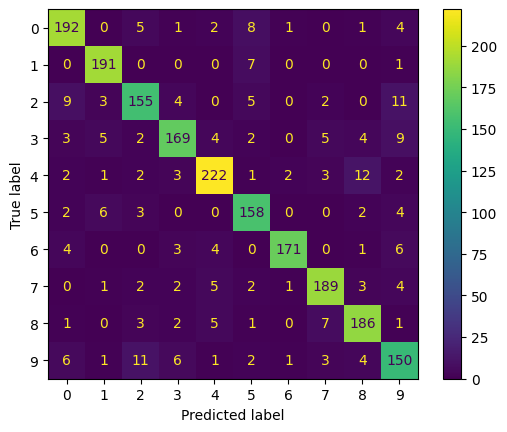

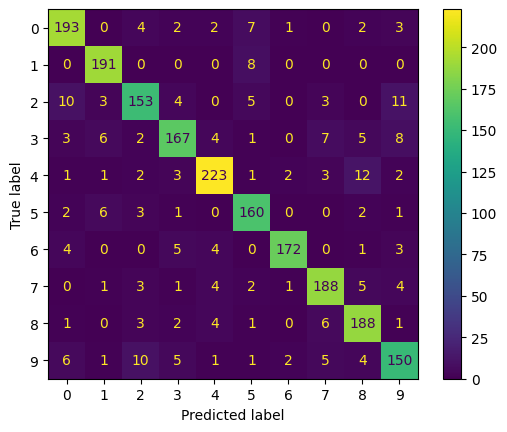

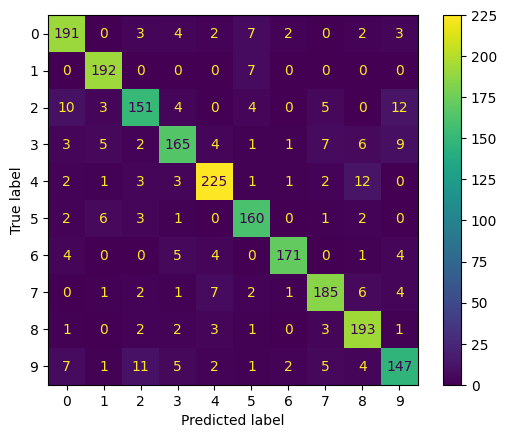

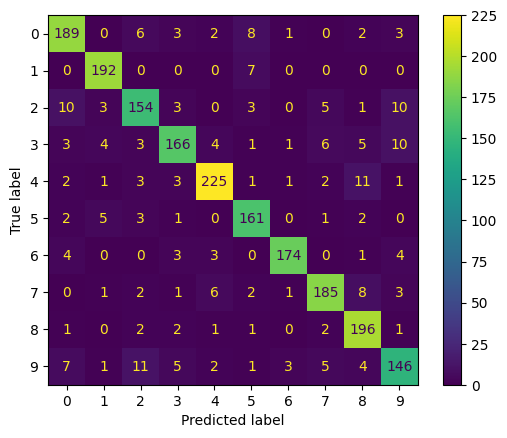

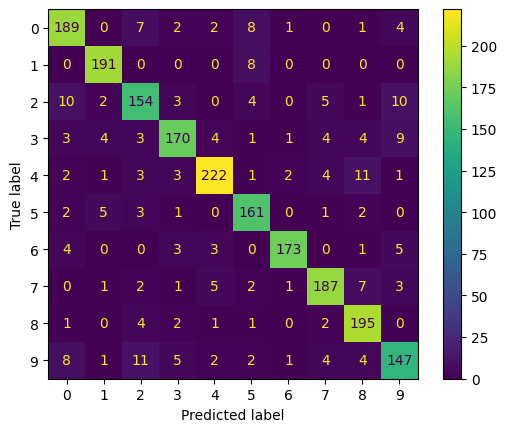

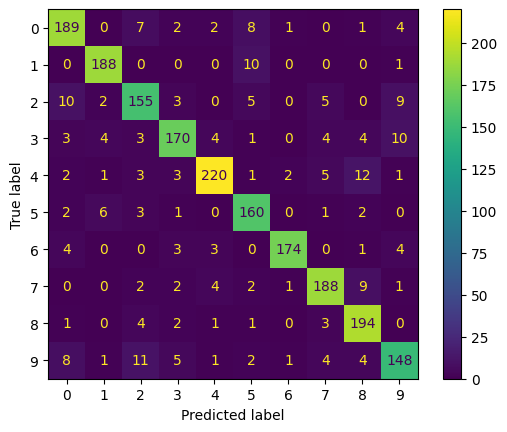

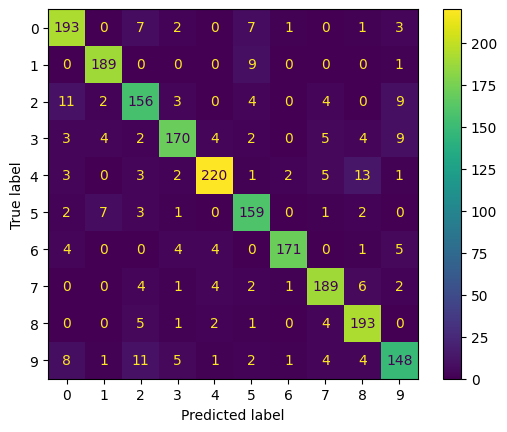

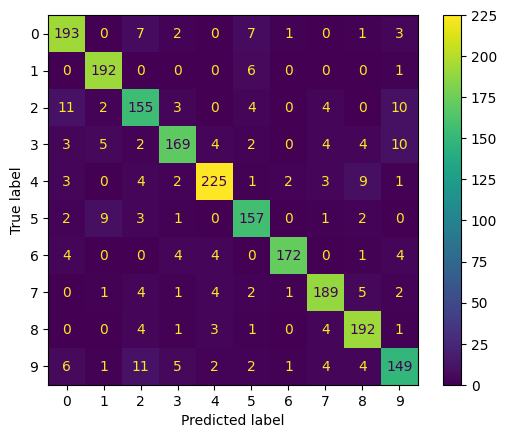

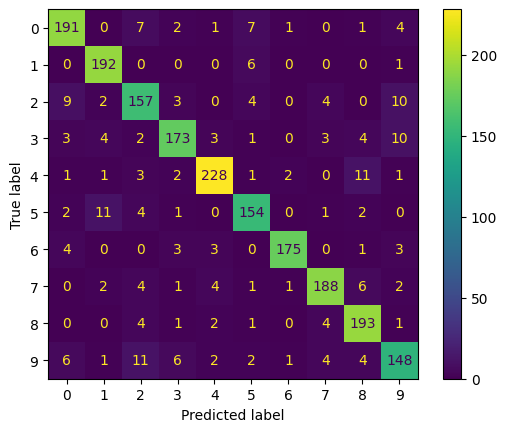

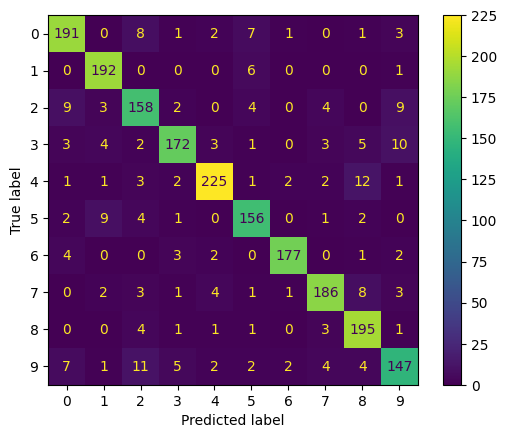

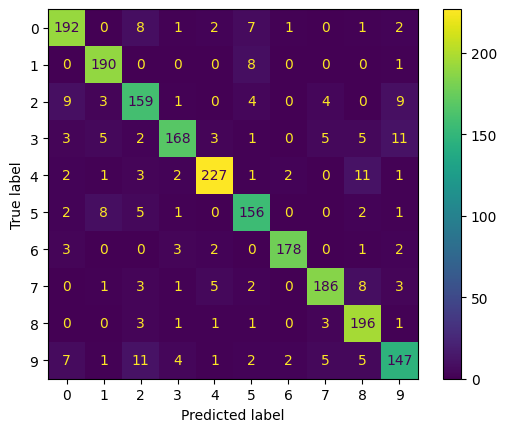

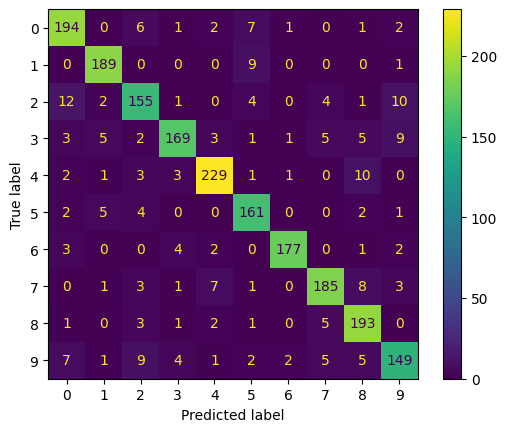

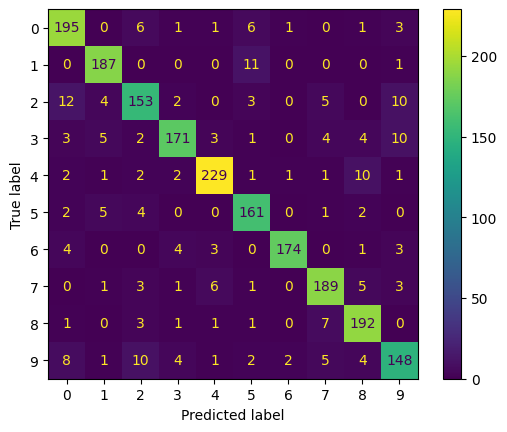

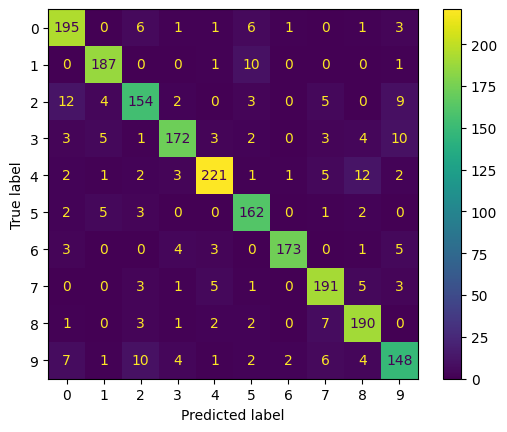

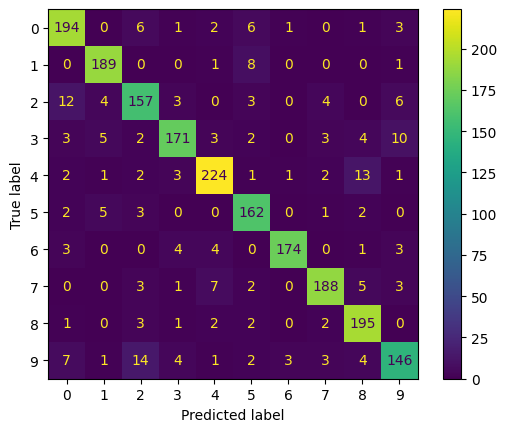

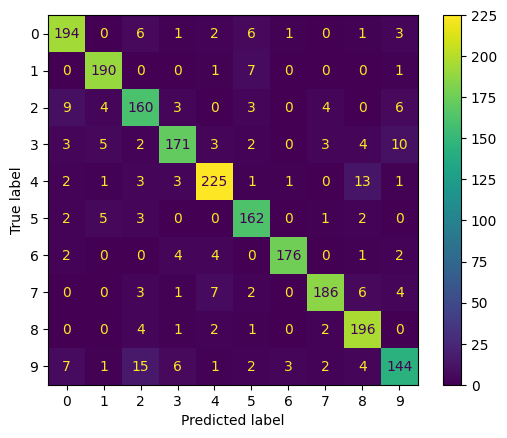

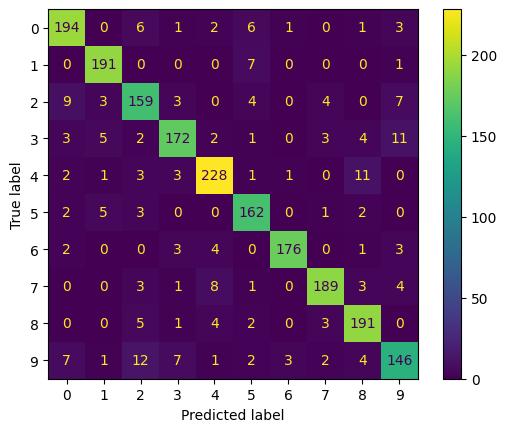

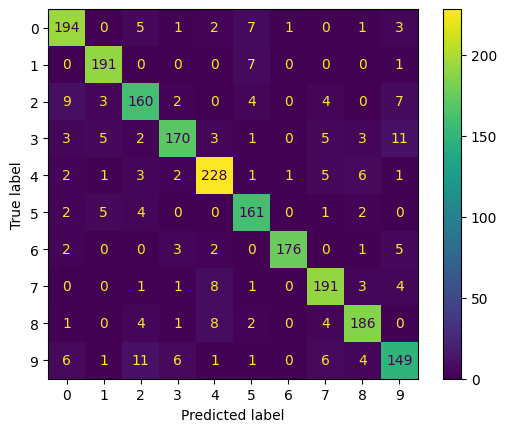

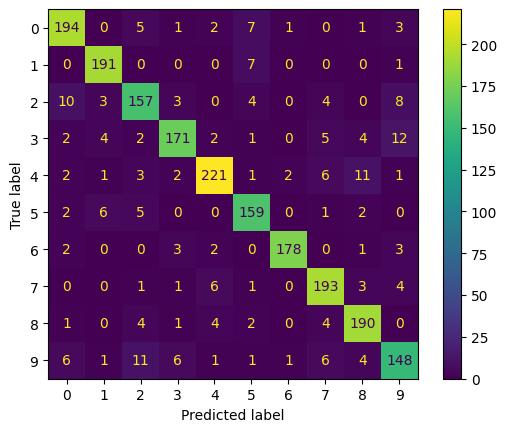

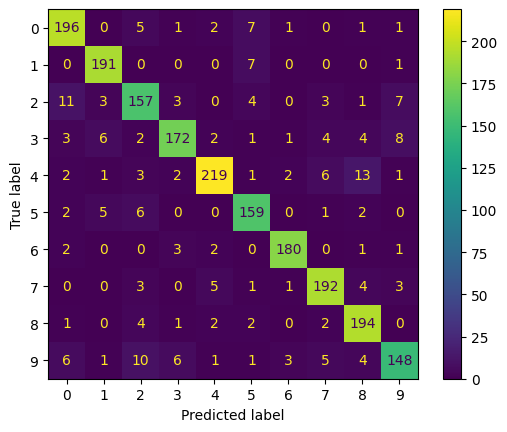

Error in callback <function flush_figures at 0x7f135287e7a0> (for post_execute):


KeyboardInterrupt: 

In [14]:
training_loop(MusicClassifier)